# Workflows and Agents

## Set up

In [1]:
import os
import getpass

from langchain_openai import ChatOpenAI

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")

llm = ChatOpenAI()

## Building Blocks: The Augmented LLM

In [2]:
# Schema for structured output
from pydantic import BaseModel, Field

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Query that is optimized web search.")
    justification: str = Field(
        None, description="Why this query is relevant to the user's request."
    )


# Augment the LLM with schema for structured output
structured_llm = llm.with_structured_output(SearchQuery)

# Invoke the augmented LLM
output = structured_llm.invoke("How does Calcium CT score relate to high cholesterol?")

# Define a tool
def multiply(a: int, b: int) -> int:
    return a * b

# Augment the LLM with tools
llm_with_tools = llm.bind_tools([multiply])

# Invoke the LLM with input that triggers the tool call
msg = llm_with_tools.invoke("What is 2 times 3?")

# Get the tool call
msg.tool_calls

[{'name': 'multiply',
  'args': {'a': 2, 'b': 3},
  'id': 'call_kTysH0x4hqzlTwmO7RJFoEXH',
  'type': 'tool_call'}]

Failed to multipart ingest runs: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('400 Client Error: Bad Request for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Bad request: invalid \'dotted_order\': dotted_order bae735e9-29e7-4959-826a-f58f2edbcb0c has timestamp 2025-04-01 19:16:05.766962 +0000 UTC earlier than parent timestamp 2025-04-01 19:16:07.287172 +0000 UTC for run_id:b29c8d34-db86-434c-9569-c7cf7ac8fa35 trace_id:9744e54e-7cb2-4dd5-b6f2-bd35dddc6cd7 dotted_order:20250401T191607287172Z9744e54e-7cb2-4dd5-b6f2-bd35dddc6cd7.20250401T191605766962Zbae735e9-29e7-4959-826a-f58f2edbcb0c.20250401T191605767463Zb29c8d34-db86-434c-9569-c7cf7ac8fa35 parent_run_id:bae735e9-29e7-4959-826a-f58f2edbcb0c"}\n')
Failed to multipart ingest runs: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('400 Client Error: Bad Request for url: ht

In [3]:
output

SearchQuery(search_query='Calcium CT score and high cholesterol relationship', justification='User is asking about the relationship between Calcium CT score and high cholesterol.')

## Prompt chaining

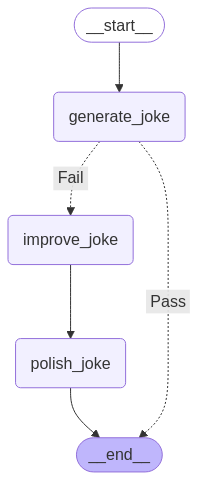

Initial joke:
Why was the cat sitting on the computer?

It wanted to keep an eye on the mouse!

--- --- ---

Improved joke:
It wanted to keep a close "paws" on the mouse!

--- --- ---

Final joke:
It turns out the cat was actually the mouse's accountant and was keeping track of all its expenses!


In [4]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display


# Graph state
class State(TypedDict):
    topic: str
    joke: str
    improved_joke: str
    final_joke: str


# Nodes
def generate_joke(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a short joke about {state['topic']}")
    return {"joke": msg.content}


def check_punchline(state: State):
    """Gate function to check if the joke has a punchline"""

    # Simple check - does the joke contain "?" or "!"
    if "?" in state["joke"] or "!" in state["joke"]:
        return "Fail"
    return "Pass"


def improve_joke(state: State):
    """Second LLM call to improve the joke"""

    msg = llm.invoke(f"Make this joke funnier by adding wordplay: {state['joke']}")
    return {"improved_joke": msg.content}


def polish_joke(state: State):
    """Third LLM call for final polish"""

    msg = llm.invoke(f"Add a surprising twist to this joke: {state['improved_joke']}")
    return {"final_joke": msg.content}


# Build workflow
workflow = StateGraph(State)

# Add nodes
workflow.add_node("generate_joke", generate_joke)
workflow.add_node("improve_joke", improve_joke)
workflow.add_node("polish_joke", polish_joke)

# Add edges to connect nodes
workflow.add_edge(START, "generate_joke")
workflow.add_conditional_edges(
    "generate_joke", check_punchline, {"Fail": "improve_joke", "Pass": END}
)
workflow.add_edge("improve_joke", "polish_joke")
workflow.add_edge("polish_joke", END)

# Compile
chain = workflow.compile()

# Show workflow
display(Image(chain.get_graph().draw_mermaid_png()))

# Invoke
state = chain.invoke({"topic": "cats"})
print("Initial joke:")
print(state["joke"])
print("\n--- --- ---\n")
if "improved_joke" in state:
    print("Improved joke:")
    print(state["improved_joke"])
    print("\n--- --- ---\n")

    print("Final joke:")
    print(state["final_joke"])
else:
    print("Joke failed quality gate - no punchline detected!")

## Parallelization

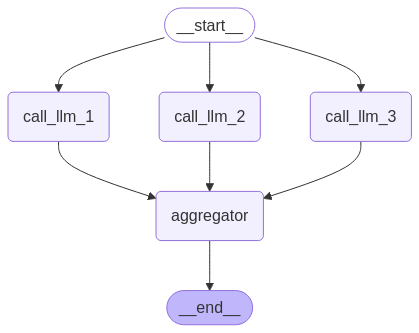

Here's a story, joke, and poem about cats!

STORY:
Once upon a time in a small town, there lived a group of cats who were known for their mischievous and playful nature. They would spend their days roaming the streets, causing trouble and getting into all sorts of mischief.

One day, the cats stumbled upon a new addition to their town - a shiny red ball that had been left unattended in the park. Curious and excited, they decided to play with it. They batted it back and forth, chasing it around and having the time of their lives.

But as they played, they didn't realize that they were being watched by a group of dogs who were not pleased with the cats' presence in the park. The dogs approached the cats, growling and barking, ready to chase them away.

The cats, sensing danger, quickly huddled together and came up with a plan. They decided to use their quick reflexes and agility to outsmart the dogs. They dashed around the park, jumping over fences and climbing trees, leading the dogs on

In [5]:
# Graph state
class State(TypedDict):
    topic: str
    joke: str
    story: str
    poem: str
    combined_output: str


# Nodes
def call_llm_1(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}


def call_llm_2(state: State):
    """Second LLM call to generate story"""

    msg = llm.invoke(f"Write a story about {state['topic']}")
    return {"story": msg.content}


def call_llm_3(state: State):
    """Third LLM call to generate poem"""

    msg = llm.invoke(f"Write a poem about {state['topic']}")
    return {"poem": msg.content}


def aggregator(state: State):
    """Combine the joke and story into a single output"""

    combined = f"Here's a story, joke, and poem about {state['topic']}!\n\n"
    combined += f"STORY:\n{state['story']}\n\n"
    combined += f"JOKE:\n{state['joke']}\n\n"
    combined += f"POEM:\n{state['poem']}"
    return {"combined_output": combined}


# Build workflow
parallel_builder = StateGraph(State)

# Add nodes
parallel_builder.add_node("call_llm_1", call_llm_1)
parallel_builder.add_node("call_llm_2", call_llm_2)
parallel_builder.add_node("call_llm_3", call_llm_3)
parallel_builder.add_node("aggregator", aggregator)

# Add edges to connect nodes
parallel_builder.add_edge(START, "call_llm_1")
parallel_builder.add_edge(START, "call_llm_2")
parallel_builder.add_edge(START, "call_llm_3")
parallel_builder.add_edge("call_llm_1", "aggregator")
parallel_builder.add_edge("call_llm_2", "aggregator")
parallel_builder.add_edge("call_llm_3", "aggregator")
parallel_builder.add_edge("aggregator", END)
parallel_workflow = parallel_builder.compile()

# Show workflow
display(Image(parallel_workflow.get_graph().draw_mermaid_png()))

# Invoke
state = parallel_workflow.invoke({"topic": "cats"})
print(state["combined_output"])

## Routing

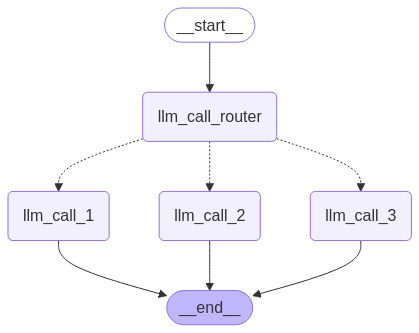

In the quiet of the night, they roam
Graceful creatures, they call home
Silent paws padding on the ground
Eyes gleaming, mischief all around

Their fur soft as velvet, sleek and black
Cats, mysterious and never lack
Of charm and beauty, they possess
A grace that leaves us all impressed

They curl up in a ball, fast asleep
Dreaming of mice and birds to keep
Their whiskers twitching in delight
As they chase imaginary prey in the night

But don't be fooled by their playful ways
For cats are fierce hunters, always ablaze
With a wild spirit that cannot be tamed
In their eyes, a spark that cannot be named

So let us admire these creatures so divine
For in their presence, peace we find
Cats, the guardians of the night
Bringing joy and comfort, a pure delight.


In [7]:
from typing_extensions import Literal
from langchain_core.messages import HumanMessage, SystemMessage
from pydantic import BaseModel


# Schema for structured output to use as routing logic
class Route(BaseModel):
    step: Literal["poem", "story", "joke"] = Field(
        None, description="The next step in the routing process"
    )


# Augment the LLM with schema for structured output
router = llm.with_structured_output(Route)


# State
class State(TypedDict):
    input: str
    decision: str
    output: str


# Nodes
def llm_call_1(state: State):
    """Write a story"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_2(state: State):
    """Write a joke"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_3(state: State):
    """Write a poem"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_router(state: State):
    """Route the input to the appropriate node"""

    # Run the augmented LLM with structured output to serve as routing logic
    decision = router.invoke(
        [
            SystemMessage(
                content="Route the input to story, joke, or poem based on the user's request."
            ),
            HumanMessage(content=state["input"]),
        ]
    )

    return {"decision": decision.step}


# Conditional edge function to route to the appropriate node
def route_decision(state: State):
    # Return the node name you want to visit next
    if state["decision"] == "story":
        return "llm_call_1"
    elif state["decision"] == "joke":
        return "llm_call_2"
    elif state["decision"] == "poem":
        return "llm_call_3"


# Build workflow
router_builder = StateGraph(State)

# Add nodes
router_builder.add_node("llm_call_1", llm_call_1)
router_builder.add_node("llm_call_2", llm_call_2)
router_builder.add_node("llm_call_3", llm_call_3)
router_builder.add_node("llm_call_router", llm_call_router)

# Add edges to connect nodes
router_builder.add_edge(START, "llm_call_router")
router_builder.add_conditional_edges(
    "llm_call_router",
    route_decision,
    {  # Name returned by route_decision : Name of next node to visit
        "llm_call_1": "llm_call_1",
        "llm_call_2": "llm_call_2",
        "llm_call_3": "llm_call_3",
    },
)
router_builder.add_edge("llm_call_1", END)
router_builder.add_edge("llm_call_2", END)
router_builder.add_edge("llm_call_3", END)

# Compile workflow
router_workflow = router_builder.compile()

# Show the workflow
display(Image(router_workflow.get_graph().draw_mermaid_png()))

# Invoke
state = router_workflow.invoke({"input": "Write me a poem about cats"})
print(state["output"])

## Orchestrator-Worker

In [12]:
from typing import Annotated, List
from pydantic import BaseModel, Field
import operator


# Schema for structured output to use in planning
class Section(BaseModel):
    name: str = Field(
        description="Name for this section of the report.",
    )
    description: str = Field(
        description="Brief overview of the main topics and concepts to be covered in this section.",
    )


class Sections(BaseModel):
    sections: List[Section] = Field(
        description="Sections of the report.",
    )


# Augment the LLM with schema for structured output
planner = llm.with_structured_output(Sections)

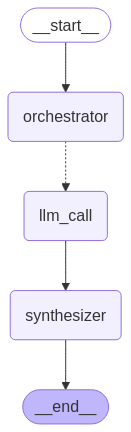

## Introduction

LLM scaling laws are fundamental relationships that describe the scaling behavior of various physical quantities in systems with similar geometries or characteristics. These scaling laws play a crucial role in understanding the underlying principles governing phenomena across different fields such as physics, engineering, and biology. By identifying and utilizing these scaling laws, researchers can make predictions, optimize designs, and analyze complex systems more efficiently. This section will explore the significance of LLM scaling laws and their applications in different disciplines.

---

## Background and Description

Scaling laws are mathematical relationships that describe how certain properties of a system change as the system's size or other relevant parameters change. These laws are widely used in various scientific disciplines to understand and predict phenomena at different scales. 

In the context of LLM (Leadership, Learning, and Management), scaling laws are applied to study how organizational characteristics, leadership strategies, and learning processes scale with the size of the organization. These laws help in understanding the behavior of organizations as they grow or evolve.

The key principles behind LLM scaling laws involve the recognition that certain aspects of organizations exhibit non-linear behaviors with respect to scale. This means that as an organization grows in size, various factors such as communication patterns, decision-making processes, and innovation capabilities do not simply increase proportionally. Instead, there are complex interactions and emergent properties that arise, leading to unique scaling relationships.

Theories behind LLM scaling laws often draw from fields such as complexity theory, systems theory, and organizational behavior. These theories help in explaining how organizations self-organize, adapt to changing environments, and exhibit patterns of growth and development that can be described by scaling laws. By applying these theories, researchers and practitioners can gain insights into how to effectively manage and lead organizations of different sizes.

---

## Examples of LLM Scaling Laws

### Physics: Example of the Square-Cube Law
The square-cube law is a scaling law in physics that describes the relationship between the volume and surface area of an object as it grows in size. This law has implications in various fields such as engineering, biology, and architecture. The law is derived from the fundamental principles of geometry and is used to understand the effects of scaling on properties like strength, weight, and heat dissipation in different systems.

### Engineering: Example of Reynolds Number in Fluid Dynamics
The Reynolds number is a scaling law in fluid dynamics that characterizes the flow regime of a fluid based on its velocity, density, viscosity, and characteristic length scale. This law is derived from the Navier-Stokes equations and is widely used to predict the behavior of fluids in various engineering applications such as pipe flow, aircraft design, and heat exchangers. Understanding the Reynolds number helps engineers optimize the design and performance of systems involving fluid flow.

### Biology: Example of Metabolic Scaling Laws
Metabolic scaling laws in biology describe the relationship between metabolic rate and body size in organisms. One of the most well-known scaling laws is Kleiber's Law, which states that metabolic rate scales to the 3/4 power of body mass. These laws are derived from principles of bioenergetics and evolutionary biology and have implications in understanding the physiology, ecology, and evolution of organisms. By applying metabolic scaling laws, researchers can make predictions about the energy requirements and ecological interactions of different species.

---

## Challenges and Limitations

LLM scaling laws face several challenges and limitations that may affect their accuracy and applicability in different scenarios. One key challenge is the assumption of linear behavior, which may not hold true in all cases, particularly when dealing with highly non-linear systems. Another limitation is the dependency on the specific dataset used for calibration, which can lead to inaccuracies when applying the laws to different datasets or scenarios. Additionally, the scaling laws may not account for all relevant factors that could influence the behavior of the system, such as environmental conditions or material properties. These limitations highlight the need for careful consideration and validation when applying LLM scaling laws in practical applications.

---

## Future Directions

- Investigate the impact of different material properties on the scaling laws to further refine and optimize the predictive models.
- Explore the application of machine learning algorithms to enhance the accuracy and efficiency of scaling law predictions.
- Conduct experimental studies to validate and verify the scaling laws across a wider range of conditions and materials.
- Develop a comprehensive database of scaling law parameters for various materials to improve the reliability and applicability of the models.
- Investigate the influence of complex geometries and boundary conditions on the scaling laws to broaden their scope and applicability.
- Collaborate with industry partners to implement scaling laws in practical engineering applications and assess their performance in real-world scenarios.

---

## Conclusion

The study on LLM scaling laws has provided valuable insights into the relationship between different parameters affecting the performance of LLMs. By analyzing the scaling laws, we have identified key trends and patterns that can help in optimizing the design and operation of LLM-based systems. The findings suggest that there are inherent relationships between size, efficiency, and other characteristics of LLMs that must be considered in their development.

Overall, understanding the scaling laws of LLMs is crucial for advancing research and innovation in scientific and engineering disciplines. By applying these principles, researchers and engineers can enhance the performance, efficiency, and reliability of LLMs in various applications. Further research in this area can lead to breakthroughs in energy conversion, thermal management, and other fields where LLMs play a vital role.

In [13]:
from langgraph.constants import Send


# Graph state
class State(TypedDict):
    topic: str  # Report topic
    sections: list[Section]  # List of report sections
    completed_sections: Annotated[
        list, operator.add
    ]  # All workers write to this key in parallel
    final_report: str  # Final report


# Worker state
class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list, operator.add]


# Nodes
def orchestrator(state: State):
    """Orchestrator that generates a plan for the report"""

    # Generate queries
    report_sections = planner.invoke(
        [
            SystemMessage(content="Generate a plan for the report."),
            HumanMessage(content=f"Here is the report topic: {state['topic']}"),
        ]
    )

    return {"sections": report_sections.sections}


def llm_call(state: WorkerState):
    """Worker writes a section of the report"""

    # Generate section
    section = llm.invoke(
        [
            SystemMessage(
                content="Write a report section following the provided name and description. Include no preamble for each section. Use markdown formatting."
            ),
            HumanMessage(
                content=f"Here is the section name: {state['section'].name} and description: {state['section'].description}"
            ),
        ]
    )

    # Write the updated section to completed sections
    return {"completed_sections": [section.content]}


def synthesizer(state: State):
    """Synthesize full report from sections"""

    # List of completed sections
    completed_sections = state["completed_sections"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = "\n\n---\n\n".join(completed_sections)

    return {"final_report": completed_report_sections}


# Conditional edge function to create llm_call workers that each write a section of the report
def assign_workers(state: State):
    """Assign a worker to each section in the plan"""

    # Kick off section writing in parallel via Send() API
    return [Send("llm_call", {"section": s}) for s in state["sections"]]


# Build workflow
orchestrator_worker_builder = StateGraph(State)

# Add the nodes
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call", llm_call)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

# Add edges to connect nodes
orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator", assign_workers, ["llm_call"]
)
orchestrator_worker_builder.add_edge("llm_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

# Compile the workflow
orchestrator_worker = orchestrator_worker_builder.compile()

# Show the workflow
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))

# Invoke
state = orchestrator_worker.invoke({"topic": "Create a report on LLM scaling laws"})

from IPython.display import Markdown
Markdown(state["final_report"])

## Evaluator-optimizer

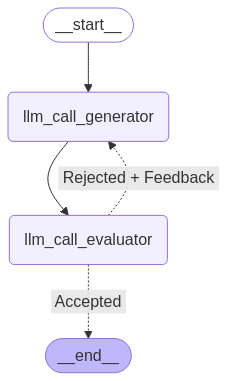

Why did the dog sit in the shade? 

Because he didn't want to be a hot dog!


In [18]:
# Graph state
class State(TypedDict):
    joke: str
    topic: str
    feedback: str
    funny_or_not: str


# Schema for structured output to use in evaluation
class Feedback(BaseModel):
    grade: Literal["funny", "not funny"] = Field(
        description="Decide if the joke is funny or not.",
    )
    feedback: str = Field(
        default='',
        description="If the joke is not funny, provide feedback on how to improve it.",
    )


# Augment the LLM with schema for structured output
evaluator = llm.with_structured_output(Feedback)


# Nodes
def llm_call_generator(state: State):
    """LLM generates a joke"""

    if state.get("feedback"):
        msg = llm.invoke(
            f"Write a joke about {state['topic']} but take into account the feedback: {state['feedback']}"
        )
    else:
        msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}


def llm_call_evaluator(state: State):
    """LLM evaluates the joke"""

    grade = evaluator.invoke(f"Grade the joke {state['joke']}")
    return {"funny_or_not": grade.grade, "feedback": grade.feedback}


# Conditional edge function to route back to joke generator or end based upon feedback from the evaluator
def route_joke(state: State):
    """Route back to joke generator or end based upon feedback from the evaluator"""

    if state["funny_or_not"] == "funny":
        return "Accepted"
    elif state["funny_or_not"] == "not funny":
        return "Rejected + Feedback"


# Build workflow
optimizer_builder = StateGraph(State)

# Add the nodes
optimizer_builder.add_node("llm_call_generator", llm_call_generator)
optimizer_builder.add_node("llm_call_evaluator", llm_call_evaluator)

# Add edges to connect nodes
optimizer_builder.add_edge(START, "llm_call_generator")
optimizer_builder.add_edge("llm_call_generator", "llm_call_evaluator")
optimizer_builder.add_conditional_edges(
    "llm_call_evaluator",
    route_joke,
    {  # Name returned by route_joke : Name of next node to visit
        "Accepted": END,
        "Rejected + Feedback": "llm_call_generator",
    },
)

# Compile the workflow
optimizer_workflow = optimizer_builder.compile()

# Show the workflow
display(Image(optimizer_workflow.get_graph().draw_mermaid_png()))

# Invoke
state = optimizer_workflow.invoke({"topic": "Dogs"})
print(state["joke"])

## Agent

In [19]:
from langchain_core.tools import tool


# Define tools
@tool
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b


@tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b


@tool
def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b


# Augment the LLM with tools
tools = [add, multiply, divide]
tools_by_name = {tool.name: tool for tool in tools}
llm_with_tools = llm.bind_tools(tools)

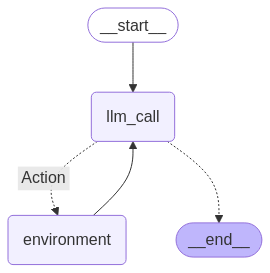

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_p1s9MrUU6iRlR06dzaelHQda)
 Call ID: call_p1s9MrUU6iRlR06dzaelHQda
  Args:
    a: 3
    b: 4
================================= Tool Message =================================

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.


In [20]:
from langgraph.graph import MessagesState
from langchain_core.messages import SystemMessage, HumanMessage, ToolMessage


# Nodes
def llm_call(state: MessagesState):
    """LLM decides whether to call a tool or not"""

    return {
        "messages": [
            llm_with_tools.invoke(
                [
                    SystemMessage(
                        content="You are a helpful assistant tasked with performing arithmetic on a set of inputs."
                    )
                ]
                + state["messages"]
            )
        ]
    }


def tool_node(state: dict):
    """Performs the tool call"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}


# Conditional edge function to route to the tool node or end based upon whether the LLM made a tool call
def should_continue(state: MessagesState) -> Literal["environment", END]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

    messages = state["messages"]
    last_message = messages[-1]
    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "Action"
    # Otherwise, we stop (reply to the user)
    return END


# Build workflow
agent_builder = StateGraph(MessagesState)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("environment", tool_node)

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        # Name returned by should_continue : Name of next node to visit
        "Action": "environment",
        END: END,
    },
)
agent_builder.add_edge("environment", "llm_call")

# Compile the agent
agent = agent_builder.compile()

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

# Invoke
messages = [HumanMessage(content="Add 3 and 4.")]
messages = agent.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()

### Pre-built

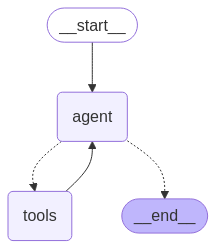

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_guS04bTo5h4rT34P0Y363QWt)
 Call ID: call_guS04bTo5h4rT34P0Y363QWt
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.


In [21]:
from langgraph.prebuilt import create_react_agent

# Pass in:
# (1) the augmented LLM with tools
# (2) the tools list (which is used to create the tool node)
pre_built_agent = create_react_agent(llm, tools=tools)

# Show the agent
display(Image(pre_built_agent.get_graph().draw_mermaid_png()))

# Invoke
messages = [HumanMessage(content="Add 3 and 4.")]
messages = pre_built_agent.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()